# Predict whether passengers would survive the sinking of the Titanic

#### Glenn Bruns, CST 383

Approximately 1,500 died when the Titanic sunk in the North Atlantic ocean in 1912.  There is data on the passengers on the Titanic, showing their sex, age, number of children, and other information, including whether or not they survived.

The purpose of this notebook is to see how well we can predict whether a passenger would survive the sinking of the Titanic using a tree classifier.  A key part of the study will be to compare the importance of predictor variables according to two different methods: the importance given by the tree classifier itself, and the importance found through forward feature selection.   

v2.3

#### Instructions:
- Please read the entire notebook carefully.
- Problems are shown in code cells below; each problem begins with #@.
- Do not make changes outside the problem cells.
- You will need to install Graphviz for this assignment.  See instructions just below.
- I provide output for some problem cells.  When I do, you should try to recreate my output, including titles, etc.
- Run your code from top to bottom before submitting.
- Do not modify the file name.

Remember to observe our course honor policy.  Do not share code with others, do not look at others' code, do not look for solutions to the problems on the web, and don't use an LLM like ChatGPT for answers to problems.  

You are of course allowed to look on the web for how to use NumPy, Pandas, etc.

#### Installing Graphviz:
Open the Anaconda Prompt (or your terminal if you're using a MacBook) and run the following command to install both the Graphviz binaries and the Python bindings:

conda install python-graphviz graphviz

This needs to be done in the same Conda environment that you use for this notebook.  Most of you will only have one environment, so this won't be an issue.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from IPython.display import display, HTML

# suppress futurewarnings only
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install graphviz

In [3]:
import sys
sys.executable

'/Users/treytodd/anaconda3/bin/python'

If you cannot install Graphviz, comment out the import below.  Then, later in the notebook, use plot_tree_custom_basic() instead of plot_tree_custom().

In [4]:
import graphviz

Plotting settings

In [5]:
sns.set_theme(context='notebook', style='whitegrid')

# set default plot size
plt.rcParams['figure.figsize'] = 6,4

In [6]:
# make the notebook width equal to 90% of the browser window width
display(HTML("<style>.container { width:90% !important; }</style>"))

### Read the data

In [7]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/titanic-new.csv"
df = pd.read_csv(input_file)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    1309 non-null   int64 
 1   Survived  1309 non-null   int64 
 2   Name      1309 non-null   object
 3   Sex       1309 non-null   object
 4   Age       1309 non-null   object
 5   SibSp     1309 non-null   int64 
 6   Parch     1309 non-null   int64 
 7   Ticket    1309 non-null   object
 8   Fare      1309 non-null   object
 9   Cabin     1309 non-null   object
 10  Embarked  1309 non-null   object
 11  Boat      1309 non-null   object
 12  Body      1309 non-null   object
 13  HomeDest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


For preliminary preprocessing, drop some variables that will not be used, and replace value '?' with np.nan wherever it appears.

In [9]:
df.drop(['Boat', 'Body', 'HomeDest'], axis=1, inplace=True)
df.replace('?', np.nan, inplace=True)

The following summary of the data shows the column names, types, and number of non-null values.

### Initial data exploration

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    1309 non-null   int64 
 1   Survived  1309 non-null   int64 
 2   Name      1309 non-null   object
 3   Sex       1309 non-null   object
 4   Age       1046 non-null   object
 5   SibSp     1309 non-null   int64 
 6   Parch     1309 non-null   int64 
 7   Ticket    1309 non-null   object
 8   Fare      1308 non-null   object
 9   Cabin     295 non-null    object
 10  Embarked  1307 non-null   object
dtypes: int64(4), object(7)
memory usage: 112.6+ KB


There is information about missing data in the df.info() output, but it is somewhat hidden.  It is helpful to visualize the missing data information.

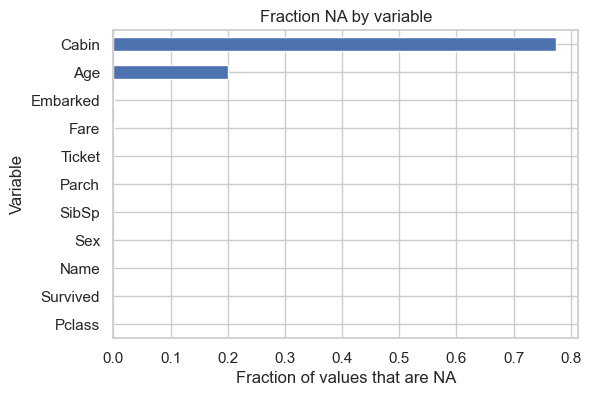

In [11]:
df.isna().mean().sort_values().plot.barh()
plt.title('Fraction NA by variable')
plt.xlabel('Fraction of values that are NA')
plt.ylabel('Variable');

Although it is not obvious from the plot above, variable 'Embarked' contains 2 missing values, and 'Fare' contains 1 missing value.

The 'Cabin' variable has lots of missing values.  What are the most common values of this variable?

In [12]:
df['Cabin'].value_counts(dropna=False)[:5]

Cabin
NaN                1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
C22 C26               4
Name: count, dtype: int64

This variable may not be very useful.  It is mostly NA, and each of the non-NA values appears only a small number of times.  Letters like 'B' and 'C' may indicate the class of the cabin.  Some of the Cabin values seem to include multiple cabin numbers.  Do some passengers get multiple cabins?  Would it be useful to convert this variable into one that just gives the number of cabins (with 0 for Nan)?

To help in confirming data types, look at the type, the number of unique values, and some of the values, for each variable.

In [13]:
df.apply([np.dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
Pclass,int64,3,"[1, 2, 3]"
Survived,int64,2,"[1, 0]"
Name,object,1307,"[Allen, Miss. Elisabeth Walton, Allison, Maste..."
Sex,object,2,"[female, male]"
Age,object,98,"[29, 0.9167, 2, 30, 25, 48, 63, 39, 53, 71, 47..."
SibSp,int64,7,"[0, 1, 2, 3, 4, 5, 8]"
Parch,int64,8,"[0, 2, 1, 4, 3, 5, 6, 9]"
Ticket,object,929,"[24160, 113781, 19952, 13502, 112050, 11769, P..."
Fare,object,281,"[211.3375, 151.55, 26.55, 77.9583, 0, 51.4792,..."
Cabin,object,186,"[B5, C22 C26, E12, D7, A36, C101, nan, C62 C64..."


Strangely, some of the 'Age' values are non-integer.  

The 'Name' values could potentially be interesting, even if only the title is useful.

The 'Ticket' values do not appear to be very interesting, although some ticket numbers are shared between passengers.  

Some of the variables which seem to be numeric have 'object' type.  In the case of 'Age', this could be because of NA values.  But why does 'Fare' have object type?

How many tickets are shared by passengers?  How many passengers share the most-shared ticket?

In [14]:
df['Ticket'].value_counts().describe()

count    929.000000
mean       1.409042
std        0.988383
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       11.000000
Name: count, dtype: float64

Most tickets aren't shared, but the most-shared ticket is shared by 11 passengers, but most tickets are not shared.  Are the passengers that share the most-shared ticket related?  Also, is the same fare shown for all passengers that share a ticket?

In [15]:
#@ 1  Show the Name and Fare values for the passengers that share the most-shared ticket.

# Hint: look at the code cell above for an idea of how to find the most-shared ticket.

most_shared = df['Ticket'].value_counts().index[0]

print(df[df['Ticket'] == most_shared][['Name', 'Fare']])

                                   Name   Fare
1170         Sage, Master. Thomas Henry  69.55
1171        Sage, Master. William Henry  69.55
1172                    Sage, Miss. Ada  69.55
1173       Sage, Miss. Constance Gladys  69.55
1174  Sage, Miss. Dorothy Edith 'Dolly'  69.55
1175            Sage, Miss. Stella Anna  69.55
1176           Sage, Mr. Douglas Bullen  69.55
1177                Sage, Mr. Frederick  69.55
1178           Sage, Mr. George John Jr  69.55
1179              Sage, Mr. John George  69.55
1180     Sage, Mrs. John (Annie Bullen)  69.55


This looks like a large family, so families may all share a single ticket.  It appears that the ticket fare is the fare paid for the single shared ticket.  In other words, it appears that \\$60.55 was the cost for the entire family to travel

Does the 'Fare' variable contain any non-numeric values besides the single NA value?

In [16]:
non_numeric = pd.to_numeric(df['Fare'], errors='coerce').isna()
df['Fare'][non_numeric]

1225    NaN
Name: Fare, dtype: object

### Data preprocessing

Convert variable 'Fare' to a numeric variable.

In [17]:
df['Fare'] = pd.to_numeric(df['Fare'], errors='coerce')

Column 'Cabin' has many unique values, but the first letter is most important, so we retain only that.  For missing values, we use a new letter 'U', for "unknown".

In [18]:
df['Cabin'] = df['Cabin'].str.slice(stop=1)
df['Cabin'].fillna('U', inplace=True)

Column 'Ticket' also has many unique values.  We simplify the variable by reducing the values to only True and False, representing whether the ticket value contains letters.

In [19]:
df['Ticket'] = df['Ticket'].str.contains('[a-zA-Z]')

Column 'Embarked' has hardly any NA values, so we drop rows of the data set with NA values for 'Embarked'.

In [20]:
df.dropna(subset=['Embarked'], inplace=True)

For column 'Name', the most important part is the title, if present.  We therefore extract the title part and create a new variable for it.  The original 'Name' column is dropped.

In [21]:
# this could be done more efficiently using Pandas.str.replace
def extract_title(s):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
    for title in titles:
        if title in s:
            return title
    return 'NoTitle'

df['Title'] = df['Name'].apply(extract_title)
df.drop(columns='Name', inplace=True)

For column age, it might be helpful to impute missing values, but this might also greatly disort the age distribution of passengers.  Instead, we will first convert the age values to age range values, and then convert any missing age values to a new 'NA' age range.

In [22]:
# convert age to a float (NA's will still exist)
df['Age'] = pd.to_numeric(df['Age'])

# create an age_range Series
age_bins = [0, 10, 20, 30, 40, 50, 100]
age_labels = [ f"({age_bins[i]},{age_bins[i+1]}]" for i in range(len(age_bins)-1)]
age_range = pd.cut(df['Age'], bins=age_bins, labels=age_labels)

# add a new 'NA' category, and convert all NA values to this category
age_range = age_range.cat.add_categories(['NA'])
age_range.fillna('NA', inplace=True)

df['Age Range'] = age_range

# drop the original Age variable
df.drop(columns='Age', inplace=True)

Remove any remaining NA values.

In [23]:
df.dropna(inplace=True)

The first rows of the preprocessed data set are shown below.

In [24]:
df.head(10)

,Pclass,Survived,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age Range
0,1,1,female,0,0,False,211.3375,B,S,Miss.,"(20,30]"
1,1,1,male,1,2,False,151.5500,C,S,Master.,"(0,10]"
2,1,0,female,1,2,False,151.5500,C,S,Miss.,"(0,10]"
3,1,0,male,1,2,False,151.5500,C,S,Mr.,"(20,30]"
4,1,0,female,1,2,False,151.5500,C,S,Mrs.,"(20,30]"
5,1,1,male,0,0,False,26.5500,E,S,Mr.,"(40,50]"
6,1,1,female,1,0,False,77.9583,D,S,Miss.,"(50,100]"
7,1,0,male,0,0,False,0.0000,A,S,Mr.,"(30,40]"
8,1,1,female,2,0,False,51.4792,C,S,Mrs.,"(50,100]"
9,1,0,male,0,0,True,49.5042,U,C,Mr.,"(50,100]"


## Data exploration

What fraction of the passengers survived?

In [25]:
print('Titanic survival rate: {:.1f} %'.format((df['Survived'] == 1).mean()*100))

Titanic survival rate: 38.1 %


What were the fares of the passengers?

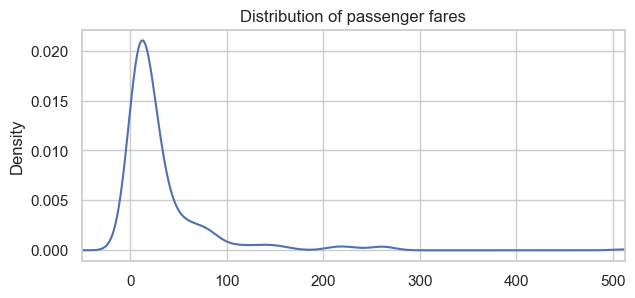

In [26]:
df['Fare'].plot.density(figsize=(7,3))
plt.xlim(-50, df['Fare'].max())
plt.title('Distribution of passenger fares');

What titles were used for passengers?  

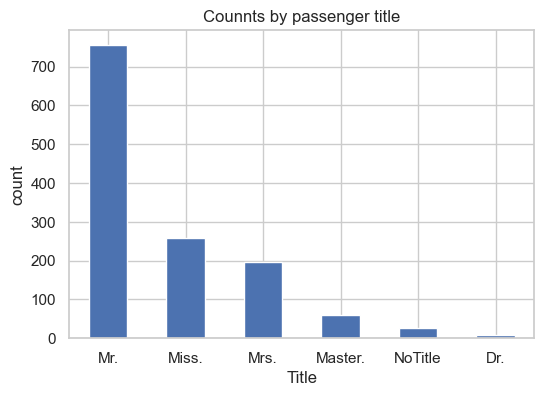

In [27]:
#@ 2  Recreate the plot of counts by passenger title.
value_counts = df['Title'].value_counts()

value_counts.plot.bar(rot=0)
plt.title('Counnts by passenger title')
plt.ylabel('count')
plt.show()

About 90\% of men have title "Mr.", while women are roughly equally split between "Miss" and "Mrs".  I believe that "Master" indicates a male child.

Examine the distribution of 'Age Range' values.

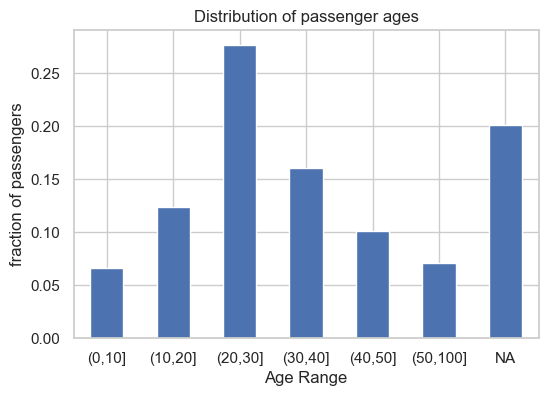

In [28]:
df['Age Range'].value_counts(normalize=True).sort_index().plot.bar(rot=0)
plt.ylabel("fraction of passengers")
plt.title("Distribution of passenger ages");

How does age relate to whether a passenger survived?

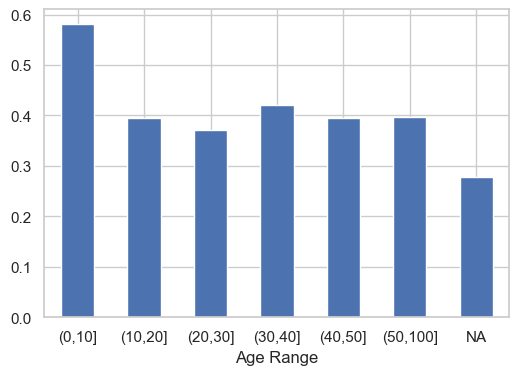

In [29]:
#@ 3  Recreate the plot of survival by age range.

survival_by_age = df.groupby('Age Range')['Survived'].sum()

totals = df.groupby('Age Range')['Survived'].count()

plotting = (survival_by_age / totals)

plotting.plot.bar(rot=0)
plt.show()

The survival rate was highest for children.  Among other age groups, the survival rate was about the same.

This plot shows the value of having a value that represents unknown ages.  The passengers of unknown age had a lower survival rate than any of the age groups.

How does gender relate to whether a passenger survived?

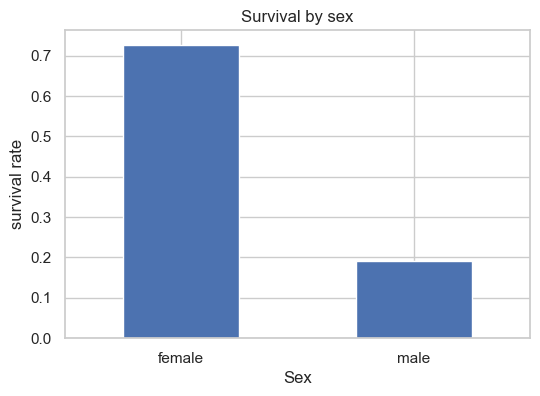

In [30]:
df.groupby('Sex')['Survived'].mean().plot.bar(rot=0)
plt.ylabel('survival rate')
plt.title('Survival by sex');

We can see that female passengers were much more likely to survive than male ones.

Do differences in the ages of female and male passengers explain why passengers in some age ranges are more likely to survive than others?

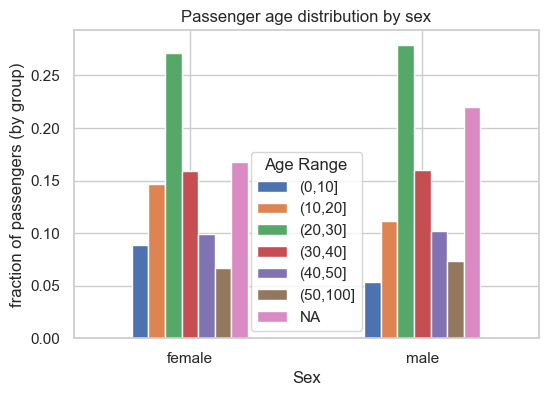

In [31]:
#@ 4  Recreate the plot of passenger age distribution by sex

# Use pd.crosstab(), as in class.

cross = pd.crosstab(df['Sex'], df['Age Range'], normalize='index')
cross.plot.bar(rot=0)
plt.title('Passenger age distribution by sex')
plt.ylabel('fraction of passengers (by group)')
plt.show()

This plot is very surprising, but helps to explain why certain ages survived.  Women passengers strongly fell into the 18-25 and 32-38 age ranges, while male passengers strongly fell into the 26-32 age range.  Very few passengers were above age 40.

Did richer passengers survive more often?  If we think of high-paying passengers as rich passengers, then looking at survival by fare may be interesting.

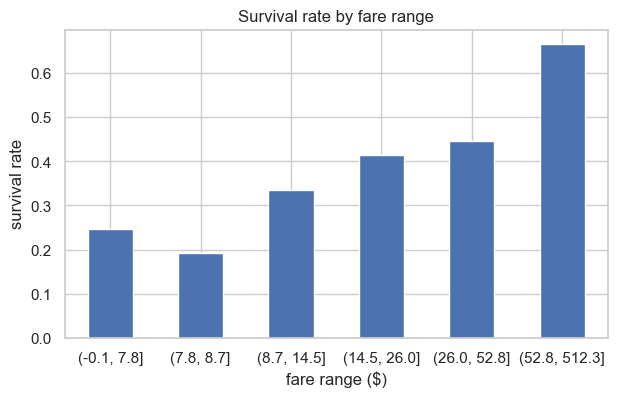

In [32]:
df.groupby(pd.qcut(df['Fare'], 6, precision=1), observed=True)['Survived'].mean().plot.bar(rot=0, figsize=(7,4))
plt.title('Survival rate by fare range')
plt.ylabel('survival rate')
plt.xlabel('fare range ($)');

In this plot, about the same number of passengers are represented in each bar.  We see that low-fare passengers had a very low survival rate, possibly because of the location of their cabins.  The wide range of fares is interesting.  About half of the passengers paid less than \\$15, but some passengers paid over \\$500.

## Machine learning

### Data preparation for machine learning

In [33]:
np.random.seed(123)

Encode categorical variables as numbers using the dummy variables method.

In [34]:
df = pd.get_dummies(df, drop_first=True)

Look at a summary of the data after the encoding.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1306 entries, 0 to 1308
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pclass              1306 non-null   int64  
 1   Survived            1306 non-null   int64  
 2   SibSp               1306 non-null   int64  
 3   Parch               1306 non-null   int64  
 4   Ticket              1306 non-null   bool   
 5   Fare                1306 non-null   float64
 6   Sex_male            1306 non-null   bool   
 7   Cabin_B             1306 non-null   bool   
 8   Cabin_C             1306 non-null   bool   
 9   Cabin_D             1306 non-null   bool   
 10  Cabin_E             1306 non-null   bool   
 11  Cabin_F             1306 non-null   bool   
 12  Cabin_G             1306 non-null   bool   
 13  Cabin_T             1306 non-null   bool   
 14  Cabin_U             1306 non-null   bool   
 15  Embarked_Q          1306 non-null   bool   
 16  Embarked_S 

Convert the Pandas data frame to NumPy arrays, and perform a train/test split.  All variables except for the target variable will be used as predictors.

In [36]:
target = 'Survived'
predictors = list(df.columns)
predictors.remove(target)

X = df[predictors].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Perform a sanity check on the training data.

In [37]:
print(X_train.shape)
print(y_train.shape)

(914, 27)
(914,)


### Compute baseline accuracy

The baseline accuracy in a classification problem tells us the accuracy we could achieve if we simply guessed the majority class.  In this case, since most passengers didn't survive, we would guess 'did not survive' in the absence of any additional information.

In [38]:
#@ 5 Compute the baseline accuracy from the target values in the training data.

# The baseline accuracy is the fraction of the training set target values that
# equal the value of the target value that appears the most in the training data.

base_value = df[target].value_counts().idxmax()
base_count = df[target].value_counts().max()

total = len(df[target])

baseline_accuracy = base_count / total

print(f"Baseline Accuracy: {baseline_accuracy:.3f}")

Baseline Accuracy: 0.619


### Building a classification tree

As usual, we will start with a flexible model in an attempt to achieve overfitting.  Afterward, we will reduce the overfitting.  I expect that with a max depth of 7 we will achieve overfitting.

In [39]:
#@ 6 Create a classification tree.

# Use the max depth that was discussed.

clf = DecisionTreeClassifier(max_depth=7, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=0)

In [40]:
def plot_tree_custom(clf, feature_names, class_names):
    """ Plot a Titanic classification tree using Graphviz. """

    dot_data = export_graphviz(clf, precision=2,
                         feature_names=feature_names,
                         proportion=True,
                         class_names=class_names,
                         filled=True, rounded=True,
                         special_characters=True)

    # plot it
    graph = graphviz.Source(dot_data)
    return graph

In [41]:
def plot_tree_custom_basic(clf, feature_names, class_names, max_depth=3):
    """ Plot a classification tree using scikit-learn's plot_tree(). """

    fig, ax = plt.subplots(figsize=(20, 10), dpi=150) 
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        proportion=True,
        fontsize=10, 
        max_depth=max_depth,
        ax=ax,
    )
    plt.show()

### Making predictions and assessing the model

With our first classification we achieve a cross-validation accuracy of about 78%.

In [42]:
#@ 7 Compute and print the cross-validation accuracy of the tree.

cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')

print(f'Cross-validation accuracy: {cv_scores.mean().round(3)}')

Cross-validation accuracy: 0.786


A learning curve will show whether we are in a high bias or high variance situation.  We expect to find that we are in a high variance situation, which indicate overfitting.

In [43]:
def plot_learning_curve(clf, X_train, y_train):
    # generate the data; average the values
    train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve, classification tree')
    plt.legend();

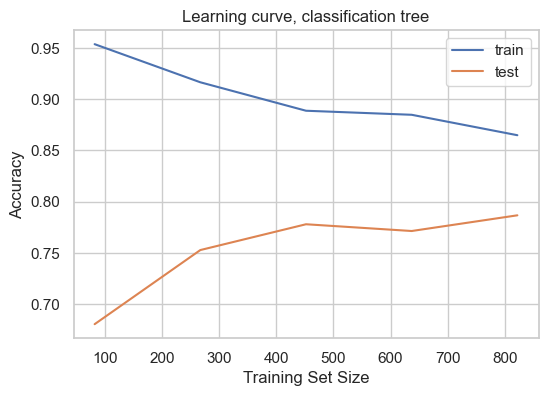

In [44]:
plot_learning_curve(clf, X_train, y_train)

This is definitely a high variance situation.

### Hyperparameter tuning

There are many hyperparameters that can be adjusted with a classification tree.  The hyperparameters min_samples_leaf and max_depth are both ways to control the depth of the tree.  max_features is an interesting hyperparameter that is used when a subset of all predictor variables are randomly selected at each node.

In [45]:
#@ 8 Perform a grid search with cross validation to perform hyperparameter tuning.

# YOUR CODE HERE
# Explore these specific parameter values:
# max_depth: values 2 through 7
# min_samples_leaf: values 10, 20, 30, 40
# max_features: values 'sqrt' and None
# Use ten folds in the cross valudation.
# Assign the grid search object you create to variable 'tree_cv'.

grid = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [10, 20, 30, 40],
    'max_features': ['sqrt', None]
}

tree_cv = GridSearchCV(estimator=clf, param_grid=grid, scoring='accuracy', cv=10)

tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=7, random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [10, 20, 30, 40]},
             scoring='accuracy')

From the grid search we learn that depth 5 is good, and that we don't want leaf nodes with less than 20 training examples.

In [46]:
print(tree_cv.best_params_)

{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20}


The cross-validation accuracy for the best tree is about 80%, which is a couple of percentage points higher than the un-tuned tree.

In [47]:
#@ 9 Print the best cross-validation accuracy found in your grid search.

# In this and the some of the following problems, it is important to remember
# that, by default, a grid search CV object will end the grid search by training
# the classifier with the best hyperparameters.  (This is controlled by the
# 'refit' parameter of GridSearchCV.  Please see the cross validation lecture
# slides for details.)

# YOUR CODE HERE
# hint: You can get the value as an attribute of tree_cv
print(f'Best Cross-Validation Accuracy: {tree_cv.best_score_:.3f}')

Best Cross-Validation Accuracy: 0.802


The learning curve for the tuned tree.

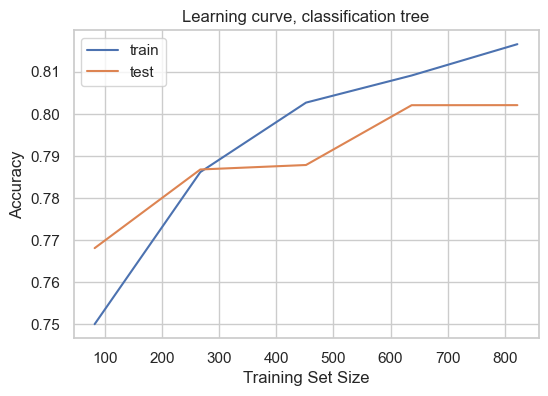

In [48]:
#@ 10 Plot the learning curve of the best tree found in grid search.

# YOUR CODE HERE
# hint: pay attention to earlier code cells
# hint: also pay attention to the next code cell

best_tree = DecisionTreeClassifier(max_depth=5, max_features=None, min_samples_leaf=20)

plot_learning_curve(best_tree, X_train, y_train)

The learning curve is a little strange looking.  First, training accuracy is increasing with training set size, while usually it decreases.  Second, the lines meet at a training size of about 300, but then separate again, showing a situation with moderate variance with the full training set.  

I would interpret this as neither a high bias nor a high variance situation.
Most importantly, we have tuned the tree to achieve highest cross-validation accuracy.

A plot of the tuned tree.  (Replace 'plot_tree_custom' with 'plot_tree_custom_basic' if you are unable to install graphviz.)

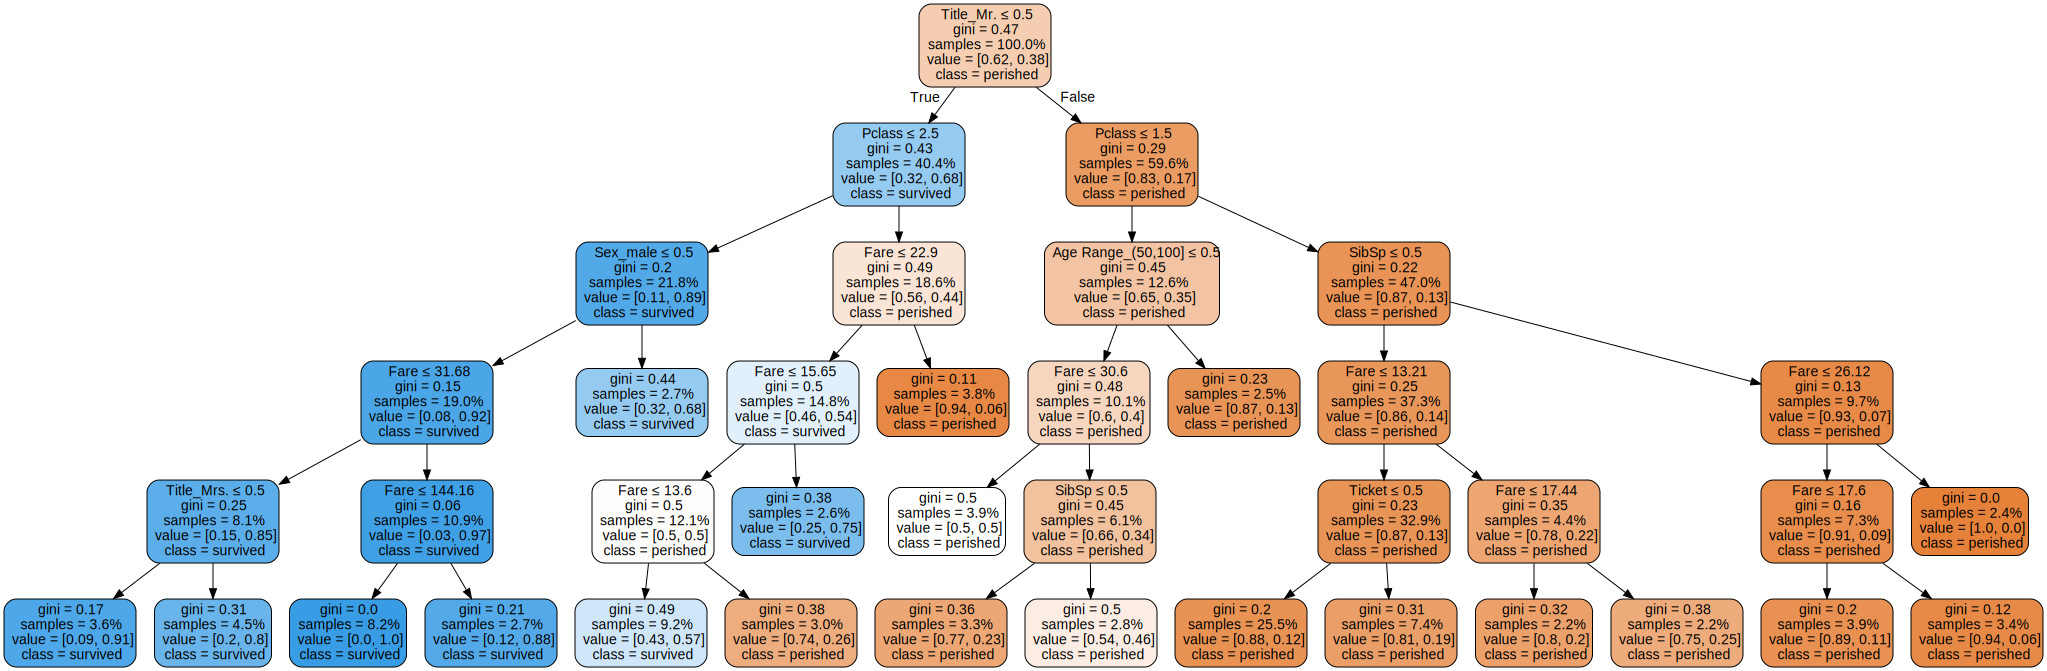

In [49]:
plot_tree_custom(tree_cv.best_estimator_, feature_names=predictors, class_names=['perished', 'survived'])

Looking at some of the leaf nodes, it looks like women with expensive tickets almost all survived, while men with cheap tickets almost all perished.

### Feature importance using the tree classifier

Feature importance values can be obtained from the trained classification tree.  Roughly, a feature is important in a tree if it is responsible for a lot of Gini reduction.

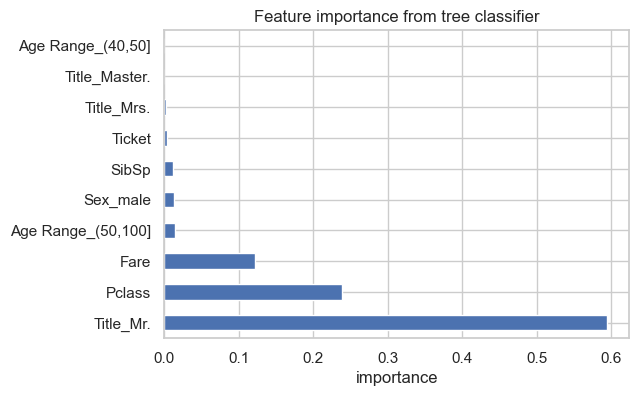

In [50]:
#@ 11 Plot the feature importance values from the best classification tree.

# YOUR CODE HERE
# Plot the importance of the ten most important features.  The bars should
# be sorted by importance and feature names must be shown.
#
# The feature importance values are an attribute of a trained classification tree.
# Hint: consider creating a Pandas series, and setting the index of the series.

best_tree.fit(X_train, y_train)

importances = best_tree.feature_importances_

series = pd.Series(importances, index=predictors)
top_features = series.sort_values(ascending=False).head(10)

top_features.plot.barh()
plt.xlabel('importance')
plt.title('Feature importance from tree classifier')
plt.show()

From this point of view, the title of "Mr." is by far the most important feature.  

### Feature importance using forward feature selection

In [51]:
#@ 12  Fill in the body of the loop

def forward_selection_classif(clf, X, y, threshold=None, num_folds=5):
    """ Perform forward feature selection with the given classifier.
    Threshold is the improvement in accuracy for the selection
    process to stop.
    threshold = None causes all features to be selected.
    """

    remaining = list(range(X.shape[1]))
    selected = []
    accuracies = []
    previous_best = 0.0
    while len(remaining) > 0:
        # YOUR CODE HERE
        # Use cross validation accuracy in computing the accuracy.
        # Use cross_val_score() to perform cross validation.
        # Use parameter num_folds to control the number of folds in cross validation.
        # Don't forget that ross_val_score() returns multiple values.
        # To test if the value of threshold is not None, you can write 'threshold is not None'
        
        # for all in x remaining
        #     compute accuracy  for fetures in selected plus x
        # append best x to selected
        # remove best x from remaining
        best_acc = 0.0
        best_feature = None
        
        for i in remaining:
            current_features = selected + [i]
            rest_of_feat = X[:, current_features]
            
            acc = cross_val_score(clf, rest_of_feat, y, cv=num_folds, scoring='accuracy').mean()

            if acc > best_acc:
                best_acc = acc
                best_feature = i

        if best_feature != None:
            selected.append(best_feature)
            remaining.remove(best_feature)
            accuracies.append(best_acc)
        
    return np.array(selected), accuracies

In [52]:
def plot_selected(selected, accuracies, predictors):
    pd.Series(accuracies, index=predictors[selected]).plot.barh()
    plt.xlim(0.5, 1.0)
    plt.xlabel('Cross-validation accuracy')
    plt.title('Result of forward feature selection')

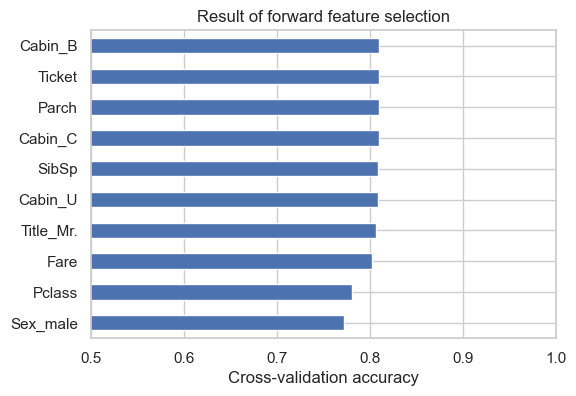

In [53]:
selected, accuracies = forward_selection_classif(tree_cv.best_estimator_, X_train, y_train, num_folds=10)
plot_selected(selected[:10], accuracies[:10], np.array(predictors))

It is hard to see the precise accuracy values from the bar plot, so print them out.

In [54]:
print(np.array(accuracies[:10]).round(4))

[0.7714 0.7802 0.802  0.8064 0.8086 0.8086 0.8097 0.8097 0.8097 0.8097]


### Test accuracy

In [55]:
#@ 13  Compute and print the test accuracy of your best tree from grid search.
# (test accuracy means accuracy on the test set)
# Hint: Don't forget that final test accuracy must be computed on a classifier.

# YOUR CODE HERE
# Print the test accuracy with 3 digits after the decimal point
best_tree = tree_cv.best_estimator_

acc = best_tree.score(X_test, y_test)

print(f'test accuracy: {acc:.3f}')

test accuracy: 0.806


### Conclusions

Througout this homework assignment we fine tuned the parameters of a decision tree.  Our initial accuracy was around 78% but with some fine tuning we were able to get the accuracy to 80.6%.

*Write your conclusions here.*